In [1]:
get_ipython().run_cell_magic('capture', '', "%logstop\n%logstart -t -r -q ipython_command_log.py global\n\n#- IRONHACKS RESEARCH TRACKING CODE\n#----------------------------------\n# The following code is used to help our research team understand how you \n# our notebook environment. We do not collect any personal information with\n# the following code, it is used to measure when and how often you work on\n# your submission files.\n\nimport os\nfrom datetime import datetime\nimport IPython.core.history as history\n\nha = history.HistoryAccessor()\nha_tail = ha.get_tail(1)\nha_cmd = next(ha_tail)\nsession_id = str(ha_cmd[0])\ncommand_id = str(ha_cmd[1])\ntimestamp = datetime.utcnow().isoformat()\nhistory_line = ','.join([session_id, command_id, timestamp]) + '\\n'\nlogfile = open(os.environ['HOME']+'/ipython_session_log.csv', 'a')\nlogfile.write(history_line)\nlogfile.close()\n")

In [2]:
get_ipython().system('pip install db-dtypes')
get_ipython().system('pip install xgboost')
get_ipython().system('pip install impyute')
get_ipython().system('pip install prophet')

In [3]:
import datetime
import itertools
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import statsmodels.api as sm
import sklearn.experimental.enable_iterative_imputer
import sklearn.impute
import sklearn.ensemble
import sklearn.model_selection
import sklearn.linear_model
import xgboost as xgb

ModuleNotFoundError: No module named 'xgboost'

In [5]:
from google.cloud import bigquery
from google.oauth2 import service_account
from google.cloud.bigquery import magics

In [6]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 1000)

In [7]:
# load data
def query(table):
    bigquery_client = bigquery.Client(project='ironhacks-data')
    query_str = f'''
SELECT *
FROM `ironhacks-data.ironhacks_competition.{table}`
'''
    query_job = bigquery_client.query(query_str)
    data = query_job.to_dataframe()
    return data

In [8]:
def combine(u, w):
    '''
    Joins the unemployment data and the wage data on `uu_id`
    '''
    ww = w.loc[:, ['uu_id', 'average_wage']]
    d = u.join(ww.set_index('uu_id'), on='uu_id')
    return d

In [9]:
def load_raw(csv_name='0_raw.csv'):
    '''
    Loads the unemployment and wage data and does some basic cleaning
    '''
    if not os.path.isfile(csv_name):
        u = query('unemployment_data')
        w = query('wage_data')
        raw = combine(u, w)
        raw.to_csv(csv_name, index=False)
    else:
        raw = pd.read_csv(csv_name)
    raw = raw.drop(['countyfips', 'tract', 'tract_name', 'timeperiod'], axis=1)
    raw = raw.sort_values(by=['uu_id', 'week_number'])
    raw = raw.drop_duplicates()
    raw = raw.replace({np.nan: None})
    raw = raw.reset_index(0, drop=True)
    return raw

In [10]:
load_raw()

,uu_id,week_number,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,edu_post_hs,edu_unknown,top_category_employer1,top_category_employer2,top_category_employer3,gender_female,gender_male,gender_na,race_amerindian,race_asian,race_black,race_noanswer,race_hawaiiannative,race_other,race_white,average_wage
0,001cd9ae23064d7f0fd3cd327c873d8d,31,34,None,0,30,None,0,31-33,23,81,None,None,0,0,0,0,0,0,0,34,10484.333333
1,001cd9ae23064d7f0fd3cd327c873d8d,33,10,None,0,None,None,0,31-33,23,81,None,None,0,0,0,0,0,0,0,10,10484.333333
2,001cd9ae23064d7f0fd3cd327c873d8d,34,25,0,0,None,None,0,62,31-33,23,None,22,None,0,0,0,None,0,0,None,10484.333333
3,001cd9ae23064d7f0fd3cd327c873d8d,35,10,None,0,None,None,0,31-33,61,23,None,None,None,0,0,0,None,0,0,None,10484.333333
4,001cd9ae23064d7f0fd3cd327c873d8d,36,10,None,0,None,None,0,31-33,23,81,None,None,None,0,0,0,None,0,0,None,10484.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13972,fec479d0202d6e1e3f051a9ee902ff5d,33,59,0,0,10,49,0,62,23,31-33,43,16,0,0,0,None,0,0,None,52,9908.312500
13973,fec479d0202d6e1e3f051a9ee902ff5d,34,34,None,0,None,25,0,23,62,61,None,21,None,0,None,None,None,0,None,26,9908.312500
13974,fec479d0202d6e1e3f051a9ee902ff5d,35,27,None,0,None,15,0,62,23,72,14,13,0,0,None,None,None,0,None,19,9908.312500
13975,fec479d0202d6e1e3f051a9ee902ff5d,36,28,None,0,None,18,0,23,62,72,12,16,0,0,None,None,None,0,None,18,9908.312500


In [11]:
# define relevant columns based on categories 
COL_MAP = {
    'edu': ['edu_8th_or_less', 'edu_grades_9_11', 'edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown'],
    'race': ['race_amerindian', 'race_asian', 'race_black', 'race_noanswer', 'race_hawaiiannative', 'race_other', 'race_white'],    
    'gender': ['gender_female', 'gender_male', 'gender_na'],
    'industry': ['top_category_employer1', 'top_category_employer2', 'top_category_employer3']        
}

In [12]:
def get_cols(names):
    l = []
    for name in names:
        if name in COL_MAP:
            l += COL_MAP[name]
        else:
            l += [name]
    return l

In [13]:
def week_number_to_date(week_number, first_week_date='20220101'):
    '''
    Prepare a date column for ARIMA
    '''
    return pd.to_datetime(first_week_date, format='%Y%m%d') + pd.DateOffset(days=7*(week_number - 1))

In [14]:
def get_subset(df, uu_id):        
    return df.loc[df.uu_id == df.uu_id.unique()[uu_id], :]

In [15]:
def convert_to_submission(results_csv, observed_label='total_claims', week_number_to_submit=40):
    r = pd.read_csv(results_csv)
    # last_few = r.loc[(30 <= r.week_number) & (r.week_number <= 37), :]
    # print('rms:', get_rms(last_few[observed_label], last_few.predicted))
    # print('mae:', get_mae(last_few[observed_label], last_few.predicted))
    last = r.loc[r.week_number == week_number_to_submit, ['uu_id', 'predicted']]
    last.index = last.uu_id
    uuid_map = last.to_dict(orient='dict')['predicted']
    p = query('prediction_list')
    p['total_claims'] = p['uu_id'].map(uuid_map)    
    p.to_csv('submission_prediction_output.csv', index=False)

In [16]:
def get_week_number_map(g, colname):
    '''
    Creates a dictionary that maps from week number to an existing value in a given `colname`
    '''
    g = g[['week_number', colname]]
    week_number_map = dict(sorted(g.values.tolist()))
    return week_number_map

In [17]:
def insert_na_week_number(g, max_week_number=43):    
    d = {}
    for colname in g.columns:
        if colname == 'week_number':
            continue
        week_number_map = get_week_number_map(g, colname)
        series = pd.Series(range(1, max_week_number+1))        
        d[colname] = series.map(week_number_map)        
        
    df = pd.DataFrame(d)
    df['week_number'] = range(1, max_week_number+1)
    df['uu_id'] = [v for v in df['uu_id'].unique() if type(v) == str][0]
    df['average_wage'] = [v for v in g['average_wage'].unique()][0]
    return df

In [18]:
def load_raw_full(csv_name='1_raw_full.csv'):
    if not os.path.isfile(csv_name):
        raw = load_raw()
        raw_full = raw.groupby('uu_id').apply(insert_na_week_number).reset_index(0, drop=True)
        raw_full['date'] = raw_full['week_number'].apply(week_number_to_date)
        raw_full.to_csv(csv_name, index=False)
        
    else:
        raw_full = pd.read_csv(csv_name)
    return raw_full

In [19]:
load_raw_full()

,uu_id,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,edu_post_hs,edu_unknown,top_category_employer1,top_category_employer2,top_category_employer3,gender_female,gender_male,gender_na,race_amerindian,race_asian,race_black,race_noanswer,race_hawaiiannative,race_other,race_white,average_wage,week_number,date
0,001cd9ae23064d7f0fd3cd327c873d8d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10484.333333,1,2022-01-01
1,001cd9ae23064d7f0fd3cd327c873d8d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10484.333333,2,2022-01-08
2,001cd9ae23064d7f0fd3cd327c873d8d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10484.333333,3,2022-01-15
3,001cd9ae23064d7f0fd3cd327c873d8d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10484.333333,4,2022-01-22
4,001cd9ae23064d7f0fd3cd327c873d8d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10484.333333,5,2022-01-29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38,fec479d0202d6e1e3f051a9ee902ff5d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9908.312500,39,2022-09-24
39,fec479d0202d6e1e3f051a9ee902ff5d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9908.312500,40,2022-10-01
40,fec479d0202d6e1e3f051a9ee902ff5d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9908.312500,41,2022-10-08
41,fec479d0202d6e1e3f051a9ee902ff5d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9908.312500,42,2022-10-15


In [20]:
def impute_iterative(df):
    '''
    Wrapper fucntion for IterativeImputer for a generic data frame. 
    Mostly, for testing. We might need need this function
    Impute data assuming there are zero columns where all the values are NA
    '''
    imputer = sklearn.impute.IterativeImputer(random_state=0, min_value=0)
    imputed_cols = imputer.fit_transform(df)
    df_imputed = pd.DataFrame(imputed_cols, columns=df.columns)
    return df_imputed

In [21]:
def plot_impute_iterative():
    raw_full = load_raw_full()
    nplots = 6
    
    fig, axs = plt.subplots(ncols=nplots, sharey=True, figsize=(15, 3))
    for i, (uu_id, g) in enumerate(raw_full.groupby('uu_id')):
        g_imp = impute_iterative(g.loc[:, ['week_number', 'total_claims']])    
        if i < nplots:
            ax = axs[i]
            ax.plot(g.week_number, g.total_claims, 'o-', zorder=10, label='raw')
            ax.plot(g_imp.week_number, g_imp.total_claims, 'o--', zorder=0, label='imputed')
            ax.set_title(f'uu_id {i}')
            ax.set_xlabel('week_number')
        # elif uu_id == 'ffbc87dc4bde6828daff6ad43e12db4a':
        #     ax = axs[-1]            
        #     ax.plot(g.week_number, g.total_claims, 'o-', zorder=10, label='raw')
        #     ax.plot(g_imp.week_number, g_imp.total_claims, 'o--', zorder=0, label='imputed')
        #     ax.set_title(f'uu_id {i}')
        #     ax.set_xlabel('week_number')

        
    axs[0].set_ylabel('total_claims')
    axs[-1].legend(frameon=False)
    plt.show()

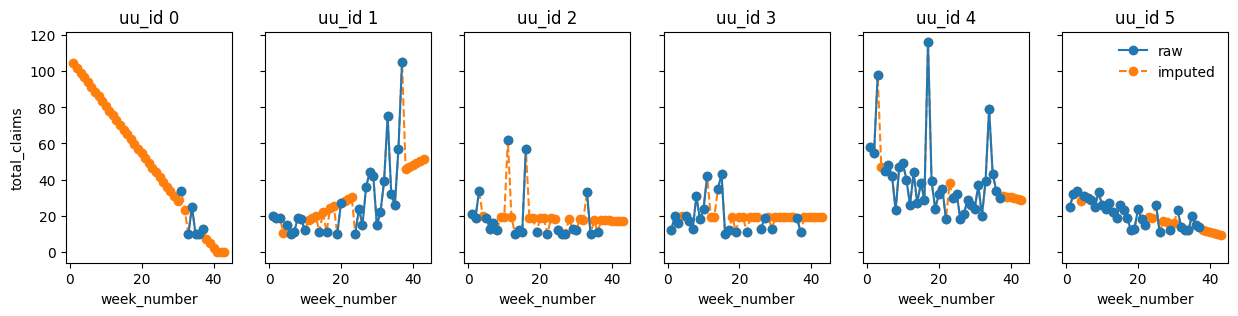

In [22]:
plot_impute_iterative()

In [23]:
def impute_total_claims(g):
    x = g.copy().reset_index(0, drop=True)
    g_imp = impute_iterative(g.loc[:, ['week_number', 'total_claims']]).reset_index(0, drop=True)
    x['total_claims'] = g_imp['total_claims']
    return x

In [24]:
def load_imp_tot(csv_name='2_imp_tot.csv'):
    if not os.path.isfile(csv_name):
        raw_full = load_raw_full()
        imp_tot = raw_full.groupby(['uu_id']).apply(impute_total_claims).reset_index(0, drop=True)
        imp_tot.to_csv(csv_name, index=False)
    else:
        imp_tot = pd.read_csv(csv_name)
    return imp_tot

In [25]:
imp_tot = load_imp_tot()
imp_tot

,uu_id,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,edu_post_hs,edu_unknown,top_category_employer1,top_category_employer2,top_category_employer3,gender_female,gender_male,gender_na,race_amerindian,race_asian,race_black,race_noanswer,race_hawaiiannative,race_other,race_white,average_wage,week_number,date
0,001cd9ae23064d7f0fd3cd327c873d8d,104.323590,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10484.333333,1,2022-01-01
1,001cd9ae23064d7f0fd3cd327c873d8d,101.703882,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10484.333333,2,2022-01-08
2,001cd9ae23064d7f0fd3cd327c873d8d,99.084175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10484.333333,3,2022-01-15
3,001cd9ae23064d7f0fd3cd327c873d8d,96.464467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10484.333333,4,2022-01-22
4,001cd9ae23064d7f0fd3cd327c873d8d,93.844759,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10484.333333,5,2022-01-29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38,fec479d0202d6e1e3f051a9ee902ff5d,26.840156,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9908.312500,39,2022-09-24
39,fec479d0202d6e1e3f051a9ee902ff5d,26.701412,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9908.312500,40,2022-10-01
40,fec479d0202d6e1e3f051a9ee902ff5d,26.562668,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9908.312500,41,2022-10-08
41,fec479d0202d6e1e3f051a9ee902ff5d,26.423924,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9908.312500,42,2022-10-15


In [26]:
def replace_na_cols(g):
    '''
    If a column only has None or zero values, replace that entire columnn with zeros
    '''
    x = g.copy()
    for col in g.columns:
        cond1 = g[col].isnull()
        cond2 = g[col] == 0
        if (cond1 | cond2).all():
            x[col] = 0        
    return x

In [27]:
def iter_cat(g):
    g = replace_na_cols(g)    
    for cat in ['edu', 'race', 'gender']:
        gg = g.loc[:, COL_MAP[cat] + ['total_claims']]
        yield cat, gg

In [28]:
def print_impute_cat(test_subset, impute_func):
    for cat, gg in iter_cat(test_subset):
        print(impute_func(gg).head())

In [29]:
print_impute_cat(get_subset(imp_tot, 6), impute_iterative)

   edu_8th_or_less  edu_grades_9_11  edu_hs_grad_equiv  edu_post_hs  edu_unknown  total_claims
0              0.0              0.0          10.355547         21.0          0.0     17.000000
1              0.0              0.0          11.000000         21.0          0.0     25.000000
2              0.0              0.0          23.000000         21.0          0.0     32.000000
3              0.0              0.0          17.446254         21.0          0.0     24.858612
4              0.0              0.0          12.000000         21.0          0.0     20.000000
   race_amerindian  race_asian  race_black  race_noanswer  race_hawaiiannative  race_other  race_white  total_claims
0              0.0         0.0   12.236978            0.0                  0.0         0.0    2.225134     17.000000
1              0.0         0.0   21.000000            0.0                  0.0         0.0    1.868450     25.000000
2              0.0         0.0   27.389486            0.0                  0.0 

In [30]:
def impute_rowsum(df, target_col='total_claims'):
    l = []
    for idx, row in df.iterrows():
        n_unknowns = row.isna().sum()        
        if n_unknowns == 1:
            others = row[~row.isna() & (row.index != target_col)]
            val = row[target_col] - others.sum()
            val = val if val > 0 else 0
            row[row.isna()] = val
        l.append(row)
    df = pd.DataFrame(l).reset_index(0, drop=True)
    
    l = []
    for idx, row in df.iterrows():
        n_unknowns = row.isna().sum()        
        
        weights = {}
        for col in row[row.isna()].index:
            weights[col] = df[col].mean()
        weights = {k:v/sum(weights.values()) for k, v in weights.items()}       
        
        if n_unknowns > 1:            
            others = row[~row.isna() & (row.index != target_col)]
            row[row.isna()] = row[row.isna()].index.map(weights)*(row[target_col] - others.sum())            
        l.append(row)
        
    df_imputed = pd.DataFrame(l).reset_index(0, drop=True)
    return df_imputed

In [31]:
print_impute_cat(get_subset(imp_tot, 6), impute_rowsum)

   edu_8th_or_less  edu_grades_9_11  edu_hs_grad_equiv  edu_post_hs  edu_unknown  total_claims
0              0.0              0.0          13.113065     3.886935          0.0     17.000000
1              0.0              0.0          11.000000    14.000000          0.0     25.000000
2              0.0              0.0          23.000000     9.000000          0.0     32.000000
3              0.0              0.0          19.174859     5.683753          0.0     24.858612
4              0.0              0.0          12.000000     8.000000          0.0     20.000000
   race_amerindian  race_asian  race_black  race_noanswer  race_hawaiiannative  race_other  race_white  total_claims
0              0.0         0.0   15.266990            0.0                  0.0         0.0    1.733010     17.000000
1              0.0         0.0   21.000000            0.0                  0.0         0.0    4.000000     25.000000
2              0.0         0.0   28.737864            0.0                  0.0 

In [32]:
def impute_all(df):
    x = df.copy().reset_index(0, drop=True)
    for cat, gg in iter_cat(df):
        df_imputed = impute_rowsum(gg)
        df_imputed = df_imputed.drop('total_claims', axis=1)
        x[COL_MAP[cat]] = df_imputed
    return x

In [33]:
def load_clean(csv_name='3_clean.csv'):    
    if not os.path.isfile(csv_name):
        imp_tot = load_imp_tot()
        imp = imp_tot.groupby('uu_id').apply(impute_all).reset_index(0, drop=True)
        imp['date'] = imp['week_number'].apply(week_number_to_date)
        imp.to_csv(csv_name, index=False)
    else:
        imp = pd.read_csv(csv_name)
    
    return imp

In [34]:
load_clean()

,uu_id,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,edu_post_hs,edu_unknown,top_category_employer1,top_category_employer2,top_category_employer3,gender_female,gender_male,gender_na,race_amerindian,race_asian,race_black,race_noanswer,race_hawaiiannative,race_other,race_white,average_wage,week_number,date
0,001cd9ae23064d7f0fd3cd327c873d8d,104.323590,0.0,0.000000,104.323590,0.000000,0.0,NaN,NaN,NaN,0.000000,104.323590,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,104.323590,10484.333333,1,2022-01-01
1,001cd9ae23064d7f0fd3cd327c873d8d,101.703882,0.0,0.000000,101.703882,0.000000,0.0,NaN,NaN,NaN,0.000000,101.703882,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,101.703882,10484.333333,2,2022-01-08
2,001cd9ae23064d7f0fd3cd327c873d8d,99.084175,0.0,0.000000,99.084175,0.000000,0.0,NaN,NaN,NaN,0.000000,99.084175,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,99.084175,10484.333333,3,2022-01-15
3,001cd9ae23064d7f0fd3cd327c873d8d,96.464467,0.0,0.000000,96.464467,0.000000,0.0,NaN,NaN,NaN,0.000000,96.464467,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,96.464467,10484.333333,4,2022-01-22
4,001cd9ae23064d7f0fd3cd327c873d8d,93.844759,0.0,0.000000,93.844759,0.000000,0.0,NaN,NaN,NaN,0.000000,93.844759,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,93.844759,10484.333333,5,2022-01-29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38,fec479d0202d6e1e3f051a9ee902ff5d,26.840156,0.0,0.871829,11.666441,14.301886,0.0,NaN,NaN,NaN,10.858411,15.981745,0.0,0.0,0.0,5.917095,0.0,0.0,0.0,20.923061,9908.312500,39,2022-09-24
39,fec479d0202d6e1e3f051a9ee902ff5d,26.701412,0.0,0.867322,11.606134,14.227956,0.0,NaN,NaN,NaN,10.802281,15.899131,0.0,0.0,0.0,5.886508,0.0,0.0,0.0,20.814904,9908.312500,40,2022-10-01
40,fec479d0202d6e1e3f051a9ee902ff5d,26.562668,0.0,0.862815,11.545827,14.154026,0.0,NaN,NaN,NaN,10.746151,15.816517,0.0,0.0,0.0,5.855921,0.0,0.0,0.0,20.706747,9908.312500,41,2022-10-08
41,fec479d0202d6e1e3f051a9ee902ff5d,26.423924,0.0,0.858309,11.485520,14.080095,0.0,NaN,NaN,NaN,10.690020,15.733903,0.0,0.0,0.0,5.825334,0.0,0.0,0.0,20.598590,9908.312500,42,2022-10-15


In [35]:
def impute_logistic(g, ycol):
    g = g[[ycol, 'week_number', 'total_claims']]
    xcols = ['week_number', 'total_claims']
    ycols = [ycol]
    
    mask_train = ~g[ycol].isnull()
    x_train, x_test = g.loc[mask_train, xcols], g.loc[~mask_train, xcols]
    y_train, y_test = g.loc[mask_train, ycols], g.loc[~mask_train, ycols]
    
    if y_train.shape[0] == 0:
        g[ycol] = None
        return g[ycol]
    
    classes = y_train[ycol].unique()
    if len(classes) == 1:
        yhat = [classes[0]]
    else:
        model = sklearn.linear_model.LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=10000).fit(x_train, y_train.values.ravel())
        yhat = model.predict(x_test)
    g.loc[~mask_train, ycols] = yhat
    return g[ycol]

In [36]:
def impute_industry(g, max_week_number=37):
    g = g.loc[g.week_number <= max_week_number, :]
    x = g.copy()
    for colname in COL_MAP['industry']:
        x[colname] = impute_logistic(g, colname)
    return x

In [37]:
def load_imp_industry(csv_name='4_imp_industry.csv'):
    if not os.path.isfile(csv_name):
        d = load_clean()
        d = d.groupby('uu_id').apply(impute_industry).reset_index(0, drop=True)
        d.to_csv(csv_name, index=False)
    else:
        d = pd.read_csv(csv_name)
    return d

In [38]:
d = load_imp_industry()
d

,uu_id,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,edu_post_hs,edu_unknown,top_category_employer1,top_category_employer2,top_category_employer3,gender_female,gender_male,gender_na,race_amerindian,race_asian,race_black,race_noanswer,race_hawaiiannative,race_other,race_white,average_wage,week_number,date
0,001cd9ae23064d7f0fd3cd327c873d8d,104.323590,0.0,0.0,104.323590,0.0,0.0,31-33,23,81,0.0,104.323590,0.0,0.0,0.0,0.0,0.0,0.0,0.0,104.323590,10484.333333,1,2022-01-01
1,001cd9ae23064d7f0fd3cd327c873d8d,101.703882,0.0,0.0,101.703882,0.0,0.0,31-33,23,81,0.0,101.703882,0.0,0.0,0.0,0.0,0.0,0.0,0.0,101.703882,10484.333333,2,2022-01-08
2,001cd9ae23064d7f0fd3cd327c873d8d,99.084175,0.0,0.0,99.084175,0.0,0.0,31-33,23,81,0.0,99.084175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99.084175,10484.333333,3,2022-01-15
3,001cd9ae23064d7f0fd3cd327c873d8d,96.464467,0.0,0.0,96.464467,0.0,0.0,31-33,23,81,0.0,96.464467,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.464467,10484.333333,4,2022-01-22
4,001cd9ae23064d7f0fd3cd327c873d8d,93.844759,0.0,0.0,93.844759,0.0,0.0,31-33,23,81,0.0,93.844759,0.0,0.0,0.0,0.0,0.0,0.0,0.0,93.844759,10484.333333,5,2022-01-29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22564,fec479d0202d6e1e3f051a9ee902ff5d,59.000000,0.0,0.0,10.000000,49.0,0.0,62,23,31-33,43.0,16.000000,0.0,0.0,0.0,7.0,0.0,0.0,0.0,52.000000,9908.312500,33,2022-08-13
22565,fec479d0202d6e1e3f051a9ee902ff5d,34.000000,0.0,0.0,9.000000,25.0,0.0,23,62,61,13.0,21.000000,0.0,0.0,0.0,8.0,0.0,0.0,0.0,26.000000,9908.312500,34,2022-08-20
22566,fec479d0202d6e1e3f051a9ee902ff5d,27.000000,0.0,0.0,12.000000,15.0,0.0,62,23,72,14.0,13.000000,0.0,0.0,0.0,8.0,0.0,0.0,0.0,19.000000,9908.312500,35,2022-08-27
22567,fec479d0202d6e1e3f051a9ee902ff5d,28.000000,0.0,0.0,10.000000,18.0,0.0,23,62,72,12.0,16.000000,0.0,0.0,0.0,10.0,0.0,0.0,0.0,18.000000,9908.312500,36,2022-09-03


In [39]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [40]:
def arimax(y, order, seasonal_order):
    model = sm.tsa.statespace.SARIMAX(y, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit(maxiter=300, disp=False)
    return results

In [41]:
def get_best_params(y, period=0):
    r1 = r2 = r3 = range(2)
    pdq = list(itertools.product(r1, r2, r3))    
    if period:
        seasonal_pdq = [(x[0], x[1], x[2], period) for x in list(itertools.product(r1, r2, r3))]
    else:
        seasonal_pdq = [(0, 0, 0, 0)]
    aic_min = np.inf
    for order in pdq:
        for seasonal_order in seasonal_pdq:
            results = arimax(y, order, seasonal_order)
            if results.aic < aic_min:
                aic_min = results.aic
                best_params = [order, seasonal_order, results.aic]            
    return best_params

In [42]:
def predict(g, ylabel='total_claims', target_week_number=41):
    g = g.loc[:, ['uu_id', 'week_number', 'date', ylabel]]
    g = g.set_index('date')
    g.index = pd.DatetimeIndex(g.index).to_period('W')
    y = g[ylabel].astype(np.float64)
    best_params = get_best_params(y)
    best_results = arimax(y, best_params[0], best_params[1])    
    pred = best_results.get_prediction(start=week_number_to_date(target_week_number - 10), end=week_number_to_date(target_week_number), dynamic=False)
    
    x = g.join(pred.predicted_mean, on=g.index, how='outer')
    x['date'] = x.key_0
    ci = pred.conf_int()
    x['ci_lower'] = ci.iloc[:, 0]
    x['ci_upper'] = ci.iloc[:, 1]
    x['uu_id'] = g['uu_id'].values[0]
    x['week_number'] = np.arange(1, target_week_number + 1)
    x['predicted'] = x['predicted_mean']
    x = x.reset_index(0, drop=True)
    return x

In [43]:
def predict_all(d, ylabel, csv_name):
    l = []
    for i, (uu_id, g) in enumerate(d.groupby('uu_id')):    
        if i % 100 == 0:
            print(f'processed {i} UUIDs')
        predicted = predict(g, ylabel=ylabel)
        l.append(predicted)
    df = pd.concat(l, ignore_index=True)
    df.to_csv(csv_name, index=False)

In [44]:
if not os.path.isfile('results_arima.csv'):
    predict_all(d, 'total_claims', 'results_arima.csv')

processed 0 UUIDs


processed 100 UUIDs


processed 200 UUIDs


processed 300 UUIDs


processed 400 UUIDs


processed 500 UUIDs


In [45]:
# now try to see if cleaning "noises" with exponentially weighted moving average (EWM) will help improve the model before doing ARIMA
# and also figure out which value of the `alpha` parameters to use
def moving_average(g, alpha=0.2): 
    x = g.copy()
    x['predicted_ewm'] = g['total_claims'].ewm(alpha=alpha).mean()    
    return x

In [46]:
def test_ewm(d, n=6):
    fig, axs = plt.subplots(ncols=n, figsize=(18, 3), sharey=True)
    for i in range(n):
        g = get_subset(d, i)        
        ax = axs[i]
        ax.plot(g.week_number, g.total_claims, 'o-', label='observed')
        for alpha in [0.6]:
            ax.plot(g.week_number, moving_average(g, alpha=alpha).predicted_ewm, '-o', label=f'predicted_ewm: alpha={alpha}')
    axs[-1].legend(fancybox=False)
    plt.show()
    plt.close()

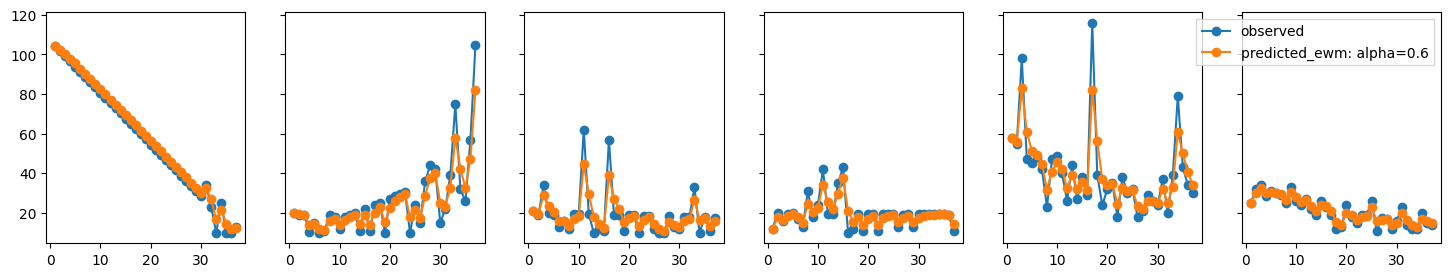

In [47]:
test_ewm(d)

it seems like alpha = 0.6 is a reasonable parameter to use for smoothing the curve without losing too much information of the peaks

In [48]:
def load_ewm(csv_name='5_ewm.csv', alpha=0.6):    
    if os.path.isfile(csv_name):
        ewm = pd.read_csv(csv_name)
    else:
        d = load_imp_industry() 
        ewm = d.groupby(['uu_id']).apply(moving_average, alpha=alpha)
        ewm.to_csv(csv_name, index=False)
        ewm['total_claims'] = ewm['predicted_ewm']
    return ewm

In [49]:
d = load_ewm()

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_13496/4155243779.py:6: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  ewm = d.groupby(['uu_id']).apply(moving_average, alpha=alpha)


In [50]:
if not os.path.isfile('results_arima_ewm.csv'):
    predict_all(load_ewm(), 'predicted_ewm', 'results_arima_ewm.csv')

processed 0 UUIDs


processed 100 UUIDs


processed 200 UUIDs


processed 300 UUIDs


processed 400 UUIDs


processed 500 UUIDs


In [51]:
def plot(ax, g):    
    for i, method in enumerate(g.method.unique()):        
        gg = g.loc[g.method == method, :]
        if i == 0:
            ax.plot(gg.week_number, gg.total_claims, 'o-', label='observed')
        ax.plot(gg.week_number, gg.predicted, 'o-', label=method)        

In [52]:
def compare_ewm():
    arma = pd.read_csv('results_arima.csv')
    arma['method'] = 'arima'
    arma_ewm = pd.read_csv('results_arima_ewm.csv')
    arma_ewm['method'] = 'arima_ewm'
    a = pd.concat([arma, arma_ewm], ignore_index=True)
    fig, axs = plt.subplots(ncols=6, figsize=(18, 3), sharey=True)
    for i, (uu_id, g) in enumerate(a.groupby('uu_id')):
        if i < 6:
            ax = axs[i]
            plot(ax, g)
            ax.set_xlabel('week_number')
            ax.set_title(f'uu_id: {i}')
    axs[0].set_ylabel('total_claims')
    axs[-1].legend(frameon=False)

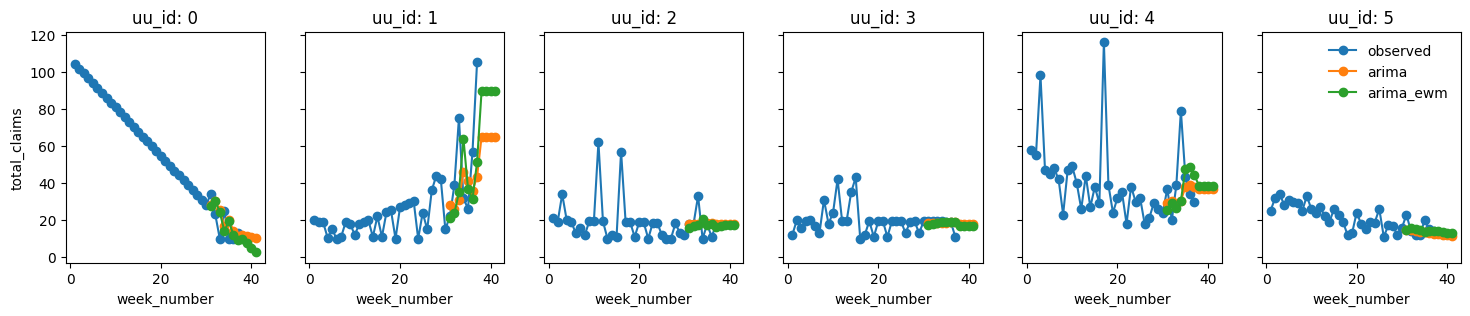

In [53]:
compare_ewm()

In [54]:
# check how good our prediction is
def get_rms(y_observed, y_predicted):
    n = len(y_observed)
    rms = sum((y_observed - y_predicted)**2)/n
    return rms

In [55]:
def get_mae(y_observed, y_predicted):
    n = len(y_observed)
    mae = sum(np.abs(y_observed - y_predicted))/n
    return mae

In [56]:
def compare_arima():
    r = pd.read_csv('results_arima.csv')
    rr = r.loc[(30 <= r.week_number) & (r.week_number <= 37), :]
    y = rr.total_claims
    yhat = rr.predicted
    print('ARIMA without EWM smoothing')
    print('rms:', get_rms(y, yhat))
    print('mae:', get_mae(y, yhat))

    rewm = pd.read_csv('results_arima_ewm.csv')
    rrewm = rewm.loc[(30 <= rewm.week_number) & (rewm.week_number <= 37), :]
    yhatewm = rrewm.predicted
    print('ARIMA with EWM smoothing')
    print('rms:', get_rms(y, yhatewm))
    print('mae:', get_mae(y, yhatewm))

In [57]:
compare_arima()

ARIMA without EWM smoothing
rms: nan
mae: nan
ARIMA with EWM smoothing
rms: nan
mae: nan


In [58]:
# Since ARIMA without smoothing seems better, we submit the corresponding results
convert_to_submission('results_arima.csv', observed_label='total_claims')

In [59]:
def get_avg_total_claims(g):
    return pd.DataFrame([{'uu_id': g.uu_id.values[0], 'average_wage': g.average_wage.values[0], 'avg_total_claims': g.total_claims.mean()}])

In [60]:
def plot_avg_total_claims(d):
    fig, axs = plt.subplots(ncols=6, figsize=(18, 3), sharey=True)
    for i, week_number in enumerate([1, 6, 11, 16, 31, 36]):        
            ax = axs[i]
            dd = d.loc[d.week_number == week_number, ['average_wage', 'total_claims']]
            ax.plot(dd.average_wage, dd.total_claims, 'o')
            ax.set_title(f'week_number: {week_number}')
            ax.set_xlabel('average_wage')
    axs[0].set_ylabel('total_claims')
    plt.show()
    plt.close()
    
    avg = d.groupby('uu_id').apply(get_avg_total_claims).reset_index(0, drop=True)
    fig, ax = plt.subplots()
    ax.plot(avg.average_wage, avg.avg_total_claims, 'o')    
    ax.set_xlabel('average_wage')
    ax.set_ylabel('average_total_claims')
    plt.show()
    plt.close()
    
    print(avg[['average_wage', 'avg_total_claims']].corr())

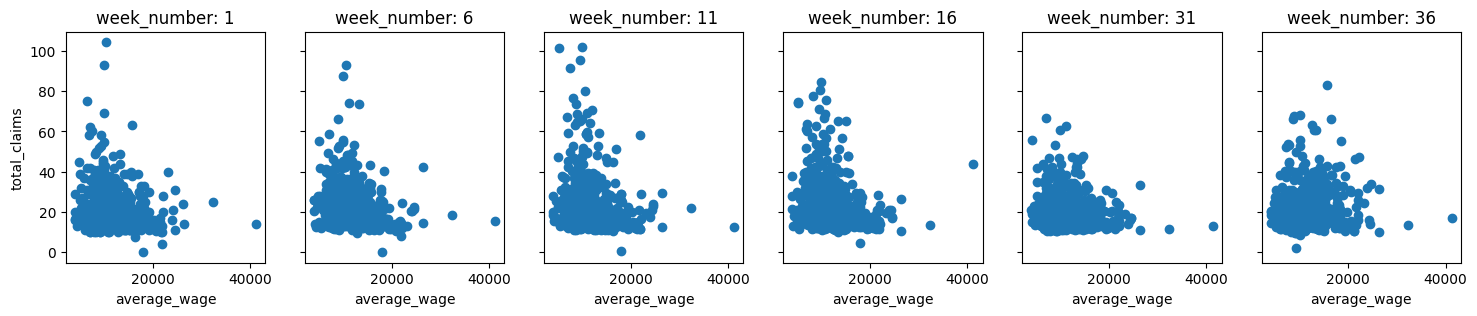

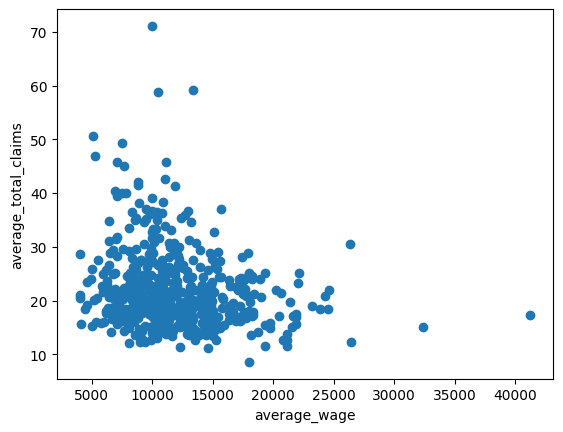

                  average_wage  avg_total_claims
average_wage          1.000000         -0.190406
avg_total_claims     -0.190406          1.000000


In [61]:
plot_avg_total_claims(d)

In [62]:
def plot_cat(d, cat):
    colnames = COL_MAP[cat]
    fig, axs = plt.subplots(ncols=6, figsize=(18, 3), sharey=True)
    for i in range(6):
        ax = axs[i]
        dd = get_subset(d, i)[['week_number'] + colnames]
        for colname in colnames:
            ax.plot(dd.week_number, dd[colname], 'o-', label=colname)
            ax.set_xlabel('week_number')
            
    axs[-1].legend(frameon=False)
    axs[0].set_ylabel('claims')
    plt.show()

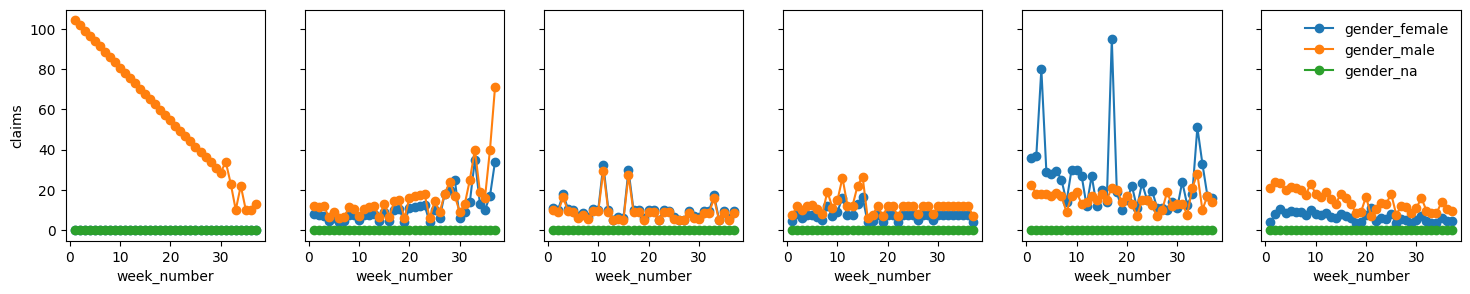

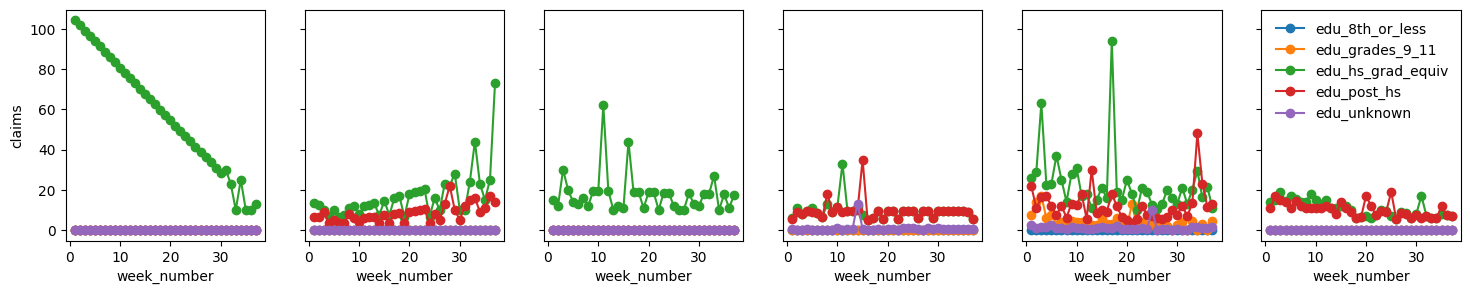

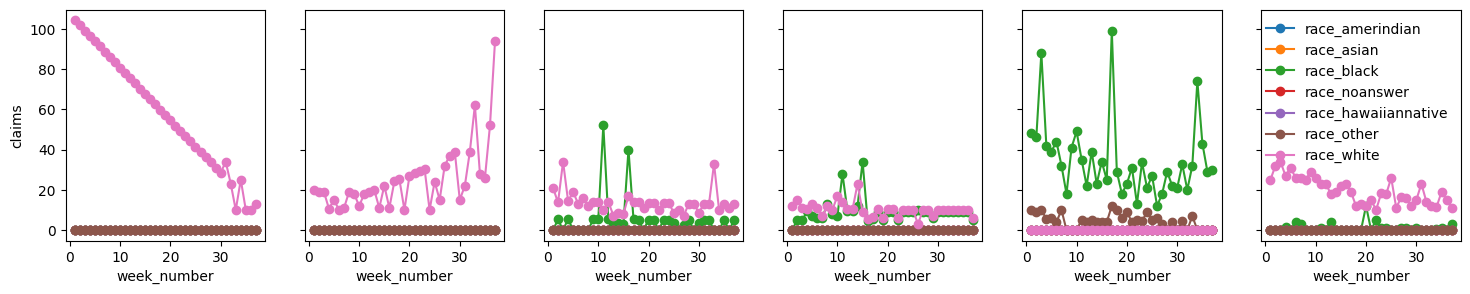

In [63]:
plot_cat(d, 'gender')
plot_cat(d, 'edu')
plot_cat(d, 'race')

In [64]:
def get_train_test(g, max_week_number=37):
    xcols = COL_MAP['edu'] + COL_MAP['gender'] + COL_MAP['race'] + ['week_number']
    ycols = ['total_claims']    
    mask_train = g.week_number <= max_week_number
    mask_test = g.week_number > max_week_number
    
    x_train, x_test = g.loc[mask_train, xcols], g.loc[mask_test, xcols]
    y_train, y_test = g.loc[mask_train, ycols], g.loc[mask_test, ycols]
    return x_train, x_test, y_train, y_test

In [65]:
def run_rf(g, max_week_number=37):
    x_train, x_test, y_train, y_test = get_train_test(g, max_week_number=max_week_number)
    rf = sklearn.ensemble.RandomForestRegressor(n_estimators=100, random_state=0).fit(x_train, y_train.values.ravel())
    yhat = rf.predict(pd.concat([x_train, x_test]))
    return x_train, x_test, y_train, y_test, yhat

In [66]:
def plot_rf(d):
    fig, axs = plt.subplots(ncols=6, figsize=(18, 3), sharey=True)
    for i in range(6):
        ax = axs[i]
        dd = get_subset(d, i)
        
        x_train, x_test, y_train, y_test, yhat = run_rf(dd)
        ax.plot(x_train.week_number, y_train, 'o-', label='original')
        ax.plot(dd.week_number, yhat, 'o-', label='predict')
        ax.set_xlabel('week_number')
        ax.set_title(f'uu_id: {i}')
            
    axs[-1].legend(frameon=False)
    axs[0].set_ylabel('claims')
    plt.show()

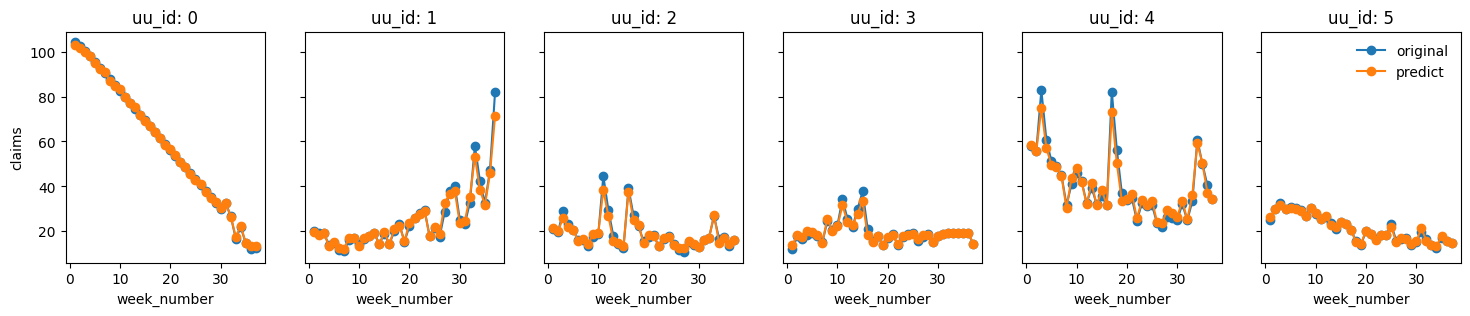

In [67]:
plot_rf(d)

In [68]:
def rf_industry(g):
    uu_id = g.uu_id.values[0]
    gg = g[COL_MAP['industry'] + ['week_number', 'total_claims']]    
    gg = gg.dropna()
    gg = pd.get_dummies(gg)
        
    if gg.shape[0] == 0:
        print(g.uu_id.values[0])
        mean = g.total_claims.mean()
        return pd.DataFrame([{'uu_id': uu_id, 'week_number': 38, 'total_claims': mean, 'predicted': mean}])
    x = gg.drop(['total_claims'], axis=1)    
    y = gg['total_claims']    
    max_avail_week_number = int(x.week_number.max())
    rf = sklearn.ensemble.RandomForestRegressor(n_estimators=100, random_state=0).fit(x, y.values.ravel())
    last = x.loc[x.week_number == max_avail_week_number, :].copy()
    last['week_number'] = max_avail_week_number + 1
    x_test = pd.concat([x, last], ignore_index=True)
    x_test['predicted'] = rf.predict(x_test)
    result = x_test.copy()
    result['total_claims'] = y.reset_index(0, drop=True)
    result['uu_id'] = uu_id
    return result[['uu_id', 'week_number', 'total_claims', 'predicted']]

In [69]:
def plot_industry(d):
    fig, axs = plt.subplots(ncols=6, figsize=(18, 3), sharey=True)
    for i in range(6):
        ax = axs[i]
        dd = get_subset(d, i)
        result = rf_industry(dd)
        ax.plot(result.week_number, result.total_claims, 'o-', label='original')
        ax.plot(result.week_number, result.predicted, 'o-', label='predict')
        ax.set_xlabel('week_number')
        ax.set_title(f'uu_id: {i}')
            
    axs[-1].legend(frameon=False)
    axs[0].set_ylabel('claims')
    plt.show()

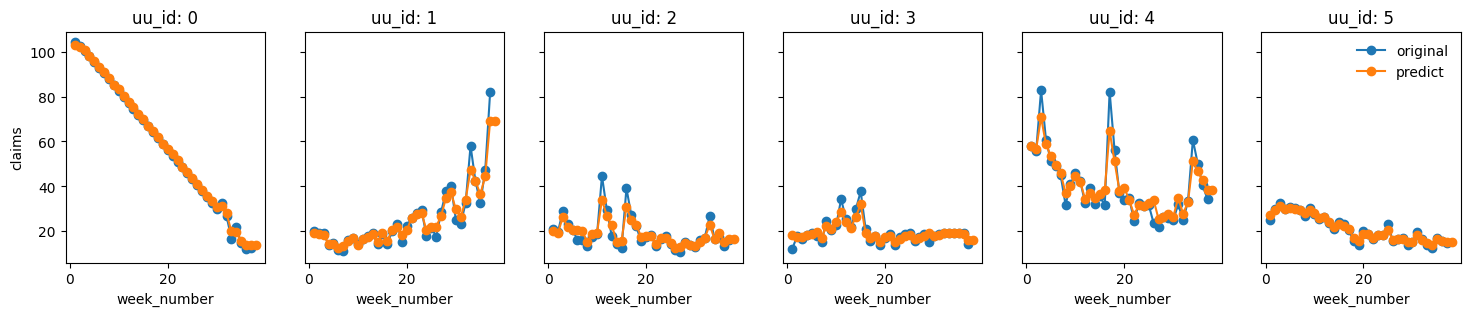

In [70]:
plot_industry(d)

In [71]:
def run_rf_all(d, csv_name='results_rf.csv'):
    if not os.path.isfile(csv_name):
        result_rf = d.groupby('uu_id').apply(rf_industry).reset_index(0, drop=True)
        result_rf.to_csv(csv_name, index=False)

In [72]:
run_rf_all(d)
convert_to_submission('results_rf.csv', observed_label='total_claims', week_number_to_submit=38)

In [73]:
from statsmodels.tsa.api import VAR

In [74]:
def get_industry(g, cat=True):
    gg = g[['uu_id', 'date', 'total_claims'] + COL_MAP['industry']]
    if cat:
        g_industry_cat = pd.get_dummies(gg[COL_MAP['industry']])
        g_no_industry = gg.loc[:, gg.columns.difference(COL_MAP['industry'])]
        gg = pd.concat([g_no_industry, g_industry_cat], axis=1)    
    return gg

In [75]:
def run_var(g):    
    g = g[['uu_id', 'date', 'total_claims'] + COL_MAP['edu'] + COL_MAP['race'] + COL_MAP['gender']]
    uu_id = g.uu_id.values[0]
    g.index = pd.DatetimeIndex(g.date)
    g.index = pd.DatetimeIndex(g.index.values, freq=g.index.inferred_freq)
    g = g.drop(['uu_id', 'date'], axis=1)
    g = g.loc[:, (g != 0).any(axis=0)]
    if g.shape[1] == 1:
        total_claims = g.iloc[:, 0].values.mean()
    else:
        var = VAR(g)
        results = var.fit(maxlags=3)
        ahead = 5
        total_claims = results.forecast(g.values[-10:], ahead)[:, 0]
    print(g['total_claims'][-6:])
    print(total_claims)
    fig, ax = plt.subplots()
    n = len(g.total_claims)
    ax.plot(range(n), g.total_claims, 'o-', color='blue')
    ax.plot(range(n, n + len(total_claims)), total_claims, 'o-', color='red')
    return pd.DataFrame([{'uu_id': uu_id, 'predicted': total_claims, 'week_number': 41}])

In [76]:
def run_var_all(d, csv_name='results_var.csv'):    
    r = d.groupby('uu_id').apply(run_var).reset_index(0, drop=True)
    r.loc[r.predicted < 0, 'predicted'] = 0
    r.to_csv(csv_name, index=False)

2022-08-06    32.701932
2022-08-13    58.080773
2022-08-20    42.432309
2022-08-27    32.572924
2022-09-03    47.229169
2022-09-10    81.891668
Freq: W-SAT, Name: total_claims, dtype: float64
[ 239.0926226   560.15870129 1263.1765764  3049.24566181 7400.61649853]


,uu_id,predicted,week_number
0,005be9532fd717dc36d4be318fd9ad25,"[239.09262260003652, 560.1587012929299, 1263.1...",41


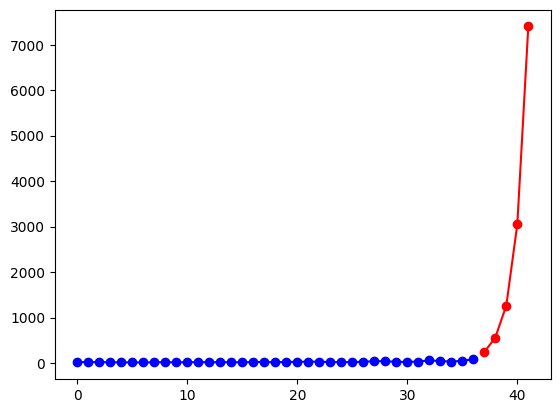

In [77]:
run_var(get_subset(d, 1))
# convert_to_submission('results_var.csv', week_number_to_submit=41)

In [78]:
def varmax(y, order, exog=None):
    mod = sm.tsa.VARMAX(y, order=order, trend='n', enforce_invertibility=False, exog=exog
            # enforce_stationarity=False,
            )
    results = mod.fit(maxiter=1000, disp=False)
    return results

In [79]:
def run_varmax(g, plot=False):
    g = g[['uu_id', 'week_number', 'date', 'total_claims'] + COL_MAP['edu'] + COL_MAP['race'] + COL_MAP['gender']]
    uu_id = g.uu_id.values[0]
    g.index = pd.DatetimeIndex(g.date)
    g.index = pd.DatetimeIndex(g.index.values, freq=g.index.inferred_freq)
    y = g.drop(['uu_id', 'week_number', 'date'], axis=1)
    y = y.loc[:, (y != 0).any(axis=0)]
    x = y.drop('total_claims', axis=1)
    if y.shape[1] <= 2:
        # total_claims = g.iloc[:, 0].values.mean()
        pass
    else:
        results = varmax(y, (2, 0), exog=x)
        predicted = results.get_prediction(start=week_number_to_date(30), end=week_number_to_date(41), dynamic=False).predicted_mean
        if plot:
            results.plot_diagnostics(figsize=(10, 7))
            fig, ax = plt.subplots()
            ax.plot(y.index, y.total_claims, 'o-')
            ax.plot(predicted.index, predicted.total_claims, 'o-')

In [80]:
def plot_varmax(d):
    for i in range(6):
        g = get_subset(d, i)
        run_varmax(g, plot=True)

In [81]:
def get_train_test(g):
    x = g[COL_MAP['edu'] + COL_MAP['race'] + COL_MAP['gender'] + ['week_number']]
    y = g['total_claims']
    last_week_number = x.week_number.max()
    x_test_last = x.loc[x.week_number == last_week_number, :].copy()
    x_test_last['week_number'] = last_week_number + 1
    x_test = pd.concat([x, x_test_last], ignore_index=True)
    return x, y, x_test

In [82]:
def run_xgb_old(g, params={'n_estimators': 1000}):
    uu_id = g.uu_id.values[0]
    x, y, x_test = get_train_test(g)
    reg = xgb.XGBRegressor(objective='reg:squarederror', **params)
    reg.fit(x, y, verbose=True)
    yhat = reg.predict(x_test)
    x_test['predicted'] = yhat
    x_test['uu_id'] = uu_id
    return x_test

In [83]:
def optimize_xgb(g):
    uu_id = g.uu_id.values[0]
    x, y, x_test = get_train_test(g)
    # params = {
    #     'min_child_weight': [1, 5, 10],
    #     'gamma': [0.3, 0.5, 1.0, 1.5, 2.0, 5.0],
    #     'subsample': [0.6, 0.8, 1.0],
    #     'colsample_bytree': [0.6, 0.8, 1.0],
    #     'max_depth': [2, 3, 4, 5],
    #     'n_estimators': [300, 600, 1000],
    #     'learning_rate': [0.001, 0.01, 0.1]
    # }
    params = {
        'min_child_weight': [1],
        'gamma': [0.3],
        'subsample': [0.6, 0.8],
        'colsample_bytree': [0.6, 0.8],
        'max_depth': [3],
        'n_estimators': [600, 1000],
        # 'learning_rate': [0.3]
    }
    reg = xgb.XGBRegressor(nthread=-1, objective='reg:squarederror')
    grid = sklearn.model_selection.GridSearchCV(reg, params)
    grid.fit(x, y)
    yhat = grid.best_estimator_.predict(x_test)
    x_test['predicted'] = yhat
    x_test['uu_id'] = uu_id
    return x_test, grid.best_score_, grid.best_params_

In [84]:
def plot_xgb(d, n=6):    
    fig, axs = plt.subplots(ncols=n, figsize=(18, 3), sharey=True)
    for i in range(n):
        ax = axs[i]
        g = get_subset(d, i)        
        pred = run_xgb_old(g)
        # pred, best_score, best_params = optimize_xgb(g)
        # print(i)
        # print(f'best score: {best_score}')
        # print('best_param: ', best_params)
        ax.plot(g.week_number, g.total_claims, 'o-')
        ax.plot(pred.week_number, pred.predicted, 'o-')    

NameError: name 'xgb' is not defined

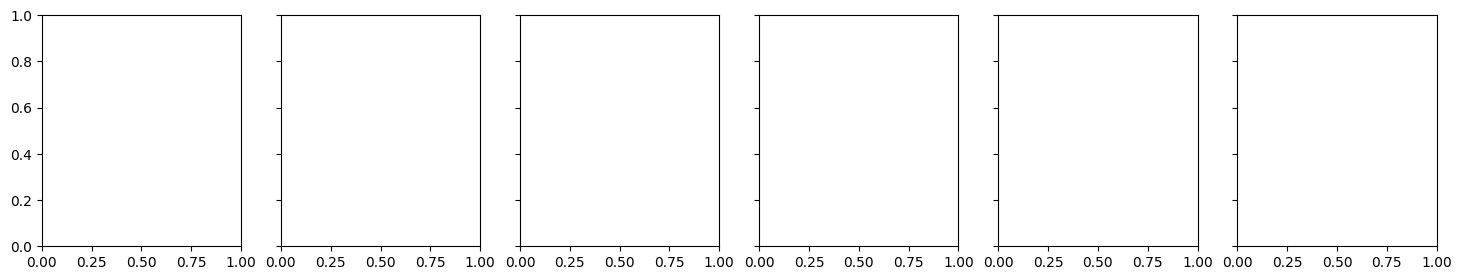

In [85]:
plot_xgb(d)
# get_train_test(get_subset(d, 6))

In [86]:
def run_xgb_all(d, csv_name='results_xgb.csv'):
    if os.path.isfile(csv_name):
        return
    l = []
    for i, (uu_id, g) in enumerate(d.groupby('uu_id')):    
        if i % 100 == 0:
            print(f'processed {i} UUIDs')
        predicted = run_xgb(g)
        l.append(predicted)
    df = pd.concat(l, ignore_index=True)
    df.to_csv(csv_name, index=False)

run_xgb_all(d)

convert_to_submission('results_xgb.csv', week_number_to_submit=38)

In [87]:
def plot(d, n=6):
    fig, axs = plt.subplots(ncols=n, sharey=True, figsize=(n*3, 3))
    for i in range(n):
        g = get_subset(d, i)
        ax = axs[i]
        ax.plot(g.week_number, g.total_claims, 'o-')
        ax.set_xlim((0, 42))

In [88]:
def get_dummies(d, cols):
    d_cat = pd.get_dummies(d.loc[:, cols])
    d_others = d.drop(cols, axis=1)
    d = pd.concat([d_others, d_cat], axis=1)
    return d

In [89]:
def get_train_test_xgb(g):
    mask_train = g.week_number <= 30
    mask_test = ~mask_train
    # x_train = g.loc[mask_train, ]

In [90]:
def preprocess_xgb(d):
    d = d[get_cols(['total_claims', 'uu_id', 'average_wage', 'week_number'])].copy()
    # d = get_dummies(d, COL_MAP['industry'])
    d['date'] = d['week_number'].apply(week_number_to_date)
    d['month'] = d['date'].dt.month
    d['quarter'] = d['date'].dt.quarter
    nlags = 3
    d['mean_month'] = d.groupby('month')['total_claims'].transform(lambda x: float(x.dropna().mean()))
    d['mean_quarter'] = d.groupby('quarter')['total_claims'].transform(lambda x: float(x.dropna().mean())) 
    
    # for lag in range(1, nlags + 1):        
    #     d[f'shift_{lag}'] = d.groupby('uu_id')['total_claims'].transform(lambda x: x.shift(lag))
    
    d = d.drop(['date'], axis=1)    
    encoder = sklearn.preprocessing.LabelEncoder()
    d['uu_id'] = encoder.fit_transform(d['uu_id'].astype(str))
    return d

In [91]:
d = load_raw_full()
# d = preprocess_xgb(d)
d

,uu_id,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,edu_post_hs,edu_unknown,top_category_employer1,top_category_employer2,top_category_employer3,gender_female,gender_male,gender_na,race_amerindian,race_asian,race_black,race_noanswer,race_hawaiiannative,race_other,race_white,average_wage,week_number,date
0,001cd9ae23064d7f0fd3cd327c873d8d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10484.333333,1,2022-01-01
1,001cd9ae23064d7f0fd3cd327c873d8d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10484.333333,2,2022-01-08
2,001cd9ae23064d7f0fd3cd327c873d8d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10484.333333,3,2022-01-15
3,001cd9ae23064d7f0fd3cd327c873d8d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10484.333333,4,2022-01-22
4,001cd9ae23064d7f0fd3cd327c873d8d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10484.333333,5,2022-01-29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22570,fec479d0202d6e1e3f051a9ee902ff5d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9908.312500,39,2022-09-24
22571,fec479d0202d6e1e3f051a9ee902ff5d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9908.312500,40,2022-10-01
22572,fec479d0202d6e1e3f051a9ee902ff5d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9908.312500,41,2022-10-08
22573,fec479d0202d6e1e3f051a9ee902ff5d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9908.312500,42,2022-10-15


In [92]:
# from impyute.imputation.cs import mice
import impyute

ModuleNotFoundError: No module named 'impyute'

In [93]:
def impute_mice(d):
    cols_numeric = ['total_claims', 'average_wage', 'week_number']
    d_numeric = d.loc[:, cols_numeric].astype('float64')
    d_numeric_imputed = impyute.imputation.cs.mice(d_numeric.values)
    d['total_claims_imputed'] = d_numeric_imputed[:, 0]
    return d

In [94]:
def plot_impute(d, n=6):
    fig, axs = plt.subplots(ncols=n, sharey=True, figsize=(n*3, 3))
    for i in range(n):
        g = get_subset(d, i)
        ax = axs[i]
        ax.plot(g.week_number, g.total_claims, 'o-', label='original')
        ax.plot(g.week_number, g.total_claims_imputed, '--', label='imputed')
        ax.set_xlim(0, 42)

In [95]:
plot_impute(impute_mice(d))

NameError: name 'impyute' is not defined

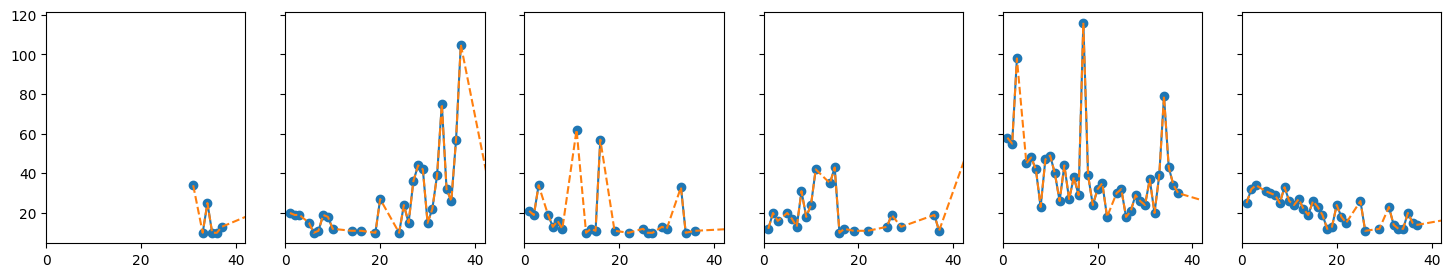

In [96]:
d = load_raw_full()
d['total_claims_imputed'] = d['total_claims'].interpolate(method='linear')
plot_impute(d)

In [97]:
d['total_claims'] = d['total_claims'].interpolate(method='linear')
d['date'] = d['week_number'].apply(week_number_to_date)
if not os.path.isfile('results_arima_linear.csv'):
    predict_all(d, 'total_claims', 'results_arima_linear.csv')

processed 0 UUIDs


ValueError: Length of values (41) does not match length of index (43)

In [98]:
d['total_claims'] = d['total_claims'].interpolate(method='linear')
d['date'] = d['week_number'].apply(week_number_to_date)
if not os.path.isfile('results_arima_linear.csv'):
    # predict_all(d, 'total_claims', 'results_arima_linear.csv')

IndentationError: expected an indented block (828360348.py, line 4)

d['total_claims'] = d['total_claims'].interpolate(method='linear')
d['date'] = d['week_number'].apply(week_number_to_date)
if not os.path.isfile('results_arima_linear.csv'):
    predict_all(d, 'total_claims', 'results_arima_linear.csv')

In [99]:
def plot_arima_linear(n=6):
    d = load_raw_full()
    r = pd.read_csv('results_arima_linear.csv')
    fig, axs = plt.subplots(ncols=n, sharey=True, figsize=(n*3, 3))
    for i in range(n):
        ax = axs[i]
        dd = get_subset(d, i)
        rr = get_subset(r, i)
        ax.plot(dd.week_number, dd.total_claims, 'o-', label='raw')
        ax.plot(rr.week_number, rr.predicted, 'o-', label='predicted')
        ax.set_xlim(0, 42)

In [100]:
plot_arima_linear()

FileNotFoundError: [Errno 2] No such file or directory: 'results_arima_linear.csv'

In [101]:
def plot_arima_linear(n=6):
    d = load_raw_full()
    r = pd.read_csv('results_arima_linear.csv')
    fig, axs = plt.subplots(ncols=n, sharey=True, figsize=(n*3, 3))
    for i in range(n):
        ax = axs[i]
        dd = get_subset(d, i)
        rr = get_subset(r, i)
        ax.plot(dd.week_number, dd.total_claims, 'o-', label='raw')
        ax.plot(rr.week_number, rr.predicted, 'o-', label='predicted')
        ax.set_xlim(0, 42)

plot_arima_linear()

In [102]:
import prophet

ModuleNotFoundError: No module named 'prophet'

In [103]:
import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

In [104]:
def run_prophet(g, period=0, growth='logistic', changepoint_range=0.8, n_changepoints=100, changepoint_prior_scale=0.75, seasonality_mode='additive', seasonality_prior_scale=10.0):
    g = g.reset_index(0, drop=True)
    gg = g.copy()
    x = pd.DataFrame({'ds': gg['date'], 'y': np.log(gg['total_claims']), 'cap': np.log(gg['total_claims']).max()})
    model = prophet.Prophet(
        weekly_seasonality=False,
        changepoint_range=changepoint_range,  
        n_changepoints=n_changepoints, 
        changepoint_prior_scale=changepoint_prior_scale,
        growth=growth,
        seasonality_mode=seasonality_mode,
        seasonality_prior_scale=seasonality_prior_scale,
        )
    if period:
        model.add_seasonality(name='monthly', period=30, fourier_order=period)
        model.add_seasonality(name='quarterly', period=90, fourier_order=period)
        model.add_seasonality(name='yearly', period=365, fourier_order=period)
    pred = model.fit(x).predict(x)
    gg['predicted'] = np.exp(pred.yhat)
    gg['predicted'] = gg['predicted'].clip(lower=0, upper=gg['total_claims'].max())
    return gg

In [105]:
def plot_prophet(n=12):
    d = load_raw_full()
    ncols = 6
    nrows = int(np.ceil(n/ncols))
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols, 3*nrows), sharex=True)
    for i in range(n):
        if i % 10 == 0:
            print(i)
        idx_row = int(i / ncols)
        idx_col = i % ncols
        if nrows == 1:
            ax = axs[idx_col]
        else:
            ax = axs[idx_row, idx_col]
        dd = get_subset(d, i)
        ax.plot(dd.week_number, dd.total_claims, 'o', label='raw')
        for growth in ['logistic', 'linear']:            
            pred = run_prophet(dd,
                growth=growth
               )
            ax.plot(pred.week_number, pred.predicted, '-', label=f'fb: {growth}')
        if idx_row == 0 and idx_col == ncols - 1:
            ax.legend()

0


NameError: name 'prophet' is not defined

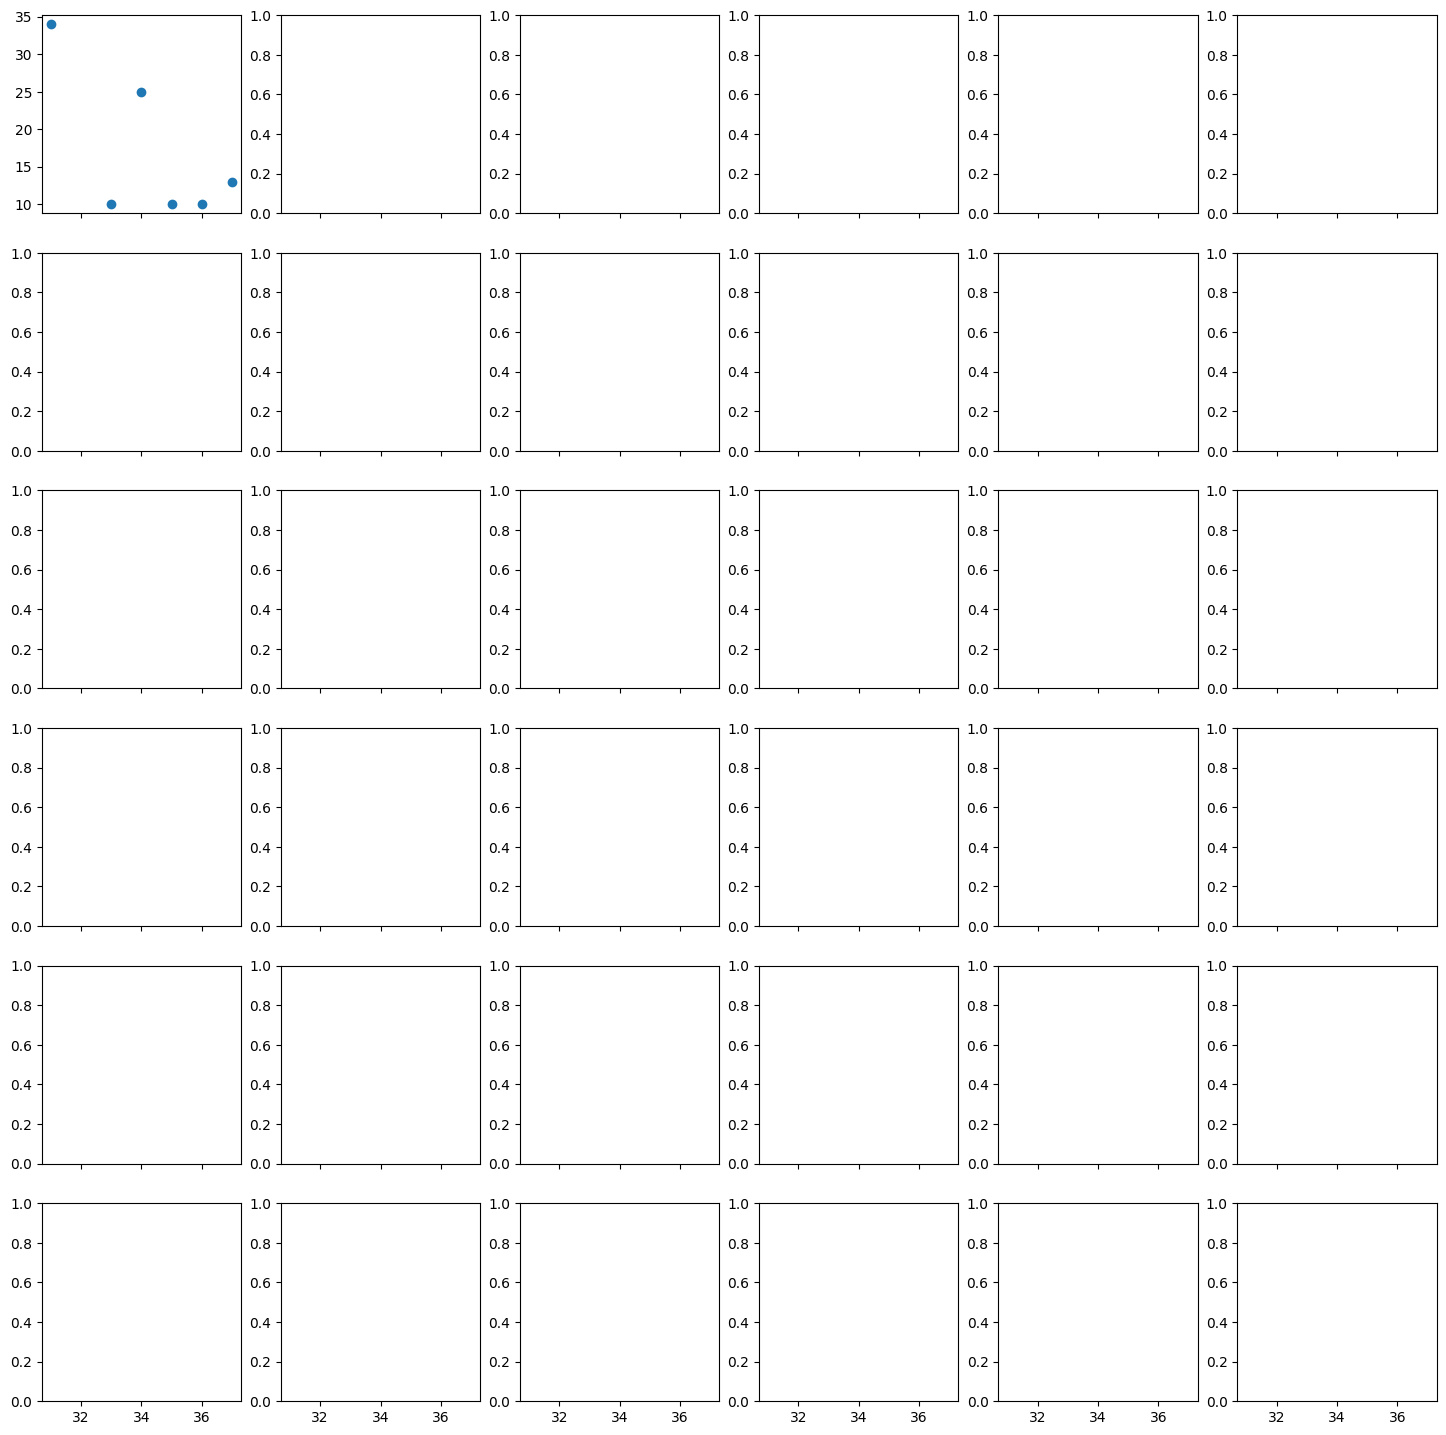

In [106]:
# d = load_raw_full()
# run_prophet(get_subset(d, 6))
plot_prophet(n=36)

In [107]:
import prophet

ModuleNotFoundError: No module named 'prophet'

In [108]:
import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

In [109]:
def run_prophet(g, period=0, growth='logistic', changepoint_range=0.8, n_changepoints=100, changepoint_prior_scale=0.75, seasonality_mode='additive', seasonality_prior_scale=10.0):
    g = g.reset_index(0, drop=True)
    gg = g.copy()
    x = pd.DataFrame({'ds': gg['date'], 'y': np.log(gg['total_claims']), 'cap': np.log(gg['total_claims']).max()})
    model = prophet.Prophet(
        weekly_seasonality=False,
        changepoint_range=changepoint_range,  
        n_changepoints=n_changepoints, 
        changepoint_prior_scale=changepoint_prior_scale,
        growth=growth,
        seasonality_mode=seasonality_mode,
        seasonality_prior_scale=seasonality_prior_scale,
        )
    if period:
        model.add_seasonality(name='monthly', period=30, fourier_order=period)
        model.add_seasonality(name='quarterly', period=90, fourier_order=period)
        model.add_seasonality(name='yearly', period=365, fourier_order=period)
    pred = model.fit(x).predict(x)
    gg['predicted'] = np.exp(pred.yhat)
    gg['predicted'] = gg['predicted'].clip(lower=0, upper=gg['total_claims'].max())
    return gg

In [110]:
def plot_prophet(n=12):
    d = load_raw_full()
    d = impute_mice(d)
    d['total_claims'] = d['total_claims_imputed']
    ncols = 6
    nrows = int(np.ceil(n/ncols))
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols, 3*nrows), sharex=True)
    for i in range(n):
        if i % 10 == 0:
            print(i)
        idx_row = int(i / ncols)
        idx_col = i % ncols
        if nrows == 1:
            ax = axs[idx_col]
        else:
            ax = axs[idx_row, idx_col]
        dd = get_subset(d, i)
        ax.plot(dd.week_number, dd.total_claims, 'o', label='raw')
        for growth in ['logistic', 'linear']:            
            pred = run_prophet(dd,
                growth=growth
               )
            ax.plot(pred.week_number, pred.predicted, '-', label=f'fb: {growth}')
        if idx_row == 0 and idx_col == ncols - 1:
            ax.legend()

In [111]:
# d = load_raw_full()
# run_prophet(get_subset(d, 6))
plot_prophet(n=36)

NameError: name 'impyute' is not defined

In [112]:
import prophet

ModuleNotFoundError: No module named 'prophet'

In [113]:
import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

In [114]:
def run_prophet(g, period=0, growth='logistic', changepoint_range=0.8, n_changepoints=100, changepoint_prior_scale=0.75, seasonality_mode='additive', seasonality_prior_scale=10.0):
    g = g.reset_index(0, drop=True)
    gg = g.copy()
    x = pd.DataFrame({'ds': gg['date'], 'y': np.log(gg['total_claims']), 'cap': np.log(gg['total_claims']).max()})
    model = prophet.Prophet(
        weekly_seasonality=False,
        changepoint_range=changepoint_range,  
        n_changepoints=n_changepoints, 
        changepoint_prior_scale=changepoint_prior_scale,
        growth=growth,
        seasonality_mode=seasonality_mode,
        seasonality_prior_scale=seasonality_prior_scale,
        )
    if period:
        model.add_seasonality(name='monthly', period=30, fourier_order=period)
        model.add_seasonality(name='quarterly', period=90, fourier_order=period)
        model.add_seasonality(name='yearly', period=365, fourier_order=period)
    pred = model.fit(x).predict(x)
    gg['predicted'] = np.exp(pred.yhat)
    gg['predicted'] = gg['predicted'].clip(lower=0, upper=gg['total_claims'].max())
    return gg

In [115]:
def plot_prophet(n=12):
    d = load_raw_full()
    # d = impute_mice(d)
    # d['total_claims'] = d['total_claims_imputed']
    d['total_claims'] = d['total_claims'].interpolate(method='linear')
    ncols = 6
    nrows = int(np.ceil(n/ncols))
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols, 3*nrows), sharex=True)
    for i in range(n):
        if i % 10 == 0:
            print(i)
        idx_row = int(i / ncols)
        idx_col = i % ncols
        if nrows == 1:
            ax = axs[idx_col]
        else:
            ax = axs[idx_row, idx_col]
        dd = get_subset(d, i)
        ax.plot(dd.week_number, dd.total_claims, 'o', label='raw')
        for growth in ['logistic', 'linear']:            
            pred = run_prophet(dd,
                growth=growth
               )
            ax.plot(pred.week_number, pred.predicted, '-', label=f'fb: {growth}')
        if idx_row == 0 and idx_col == ncols - 1:
            ax.legend()

0


NameError: name 'prophet' is not defined

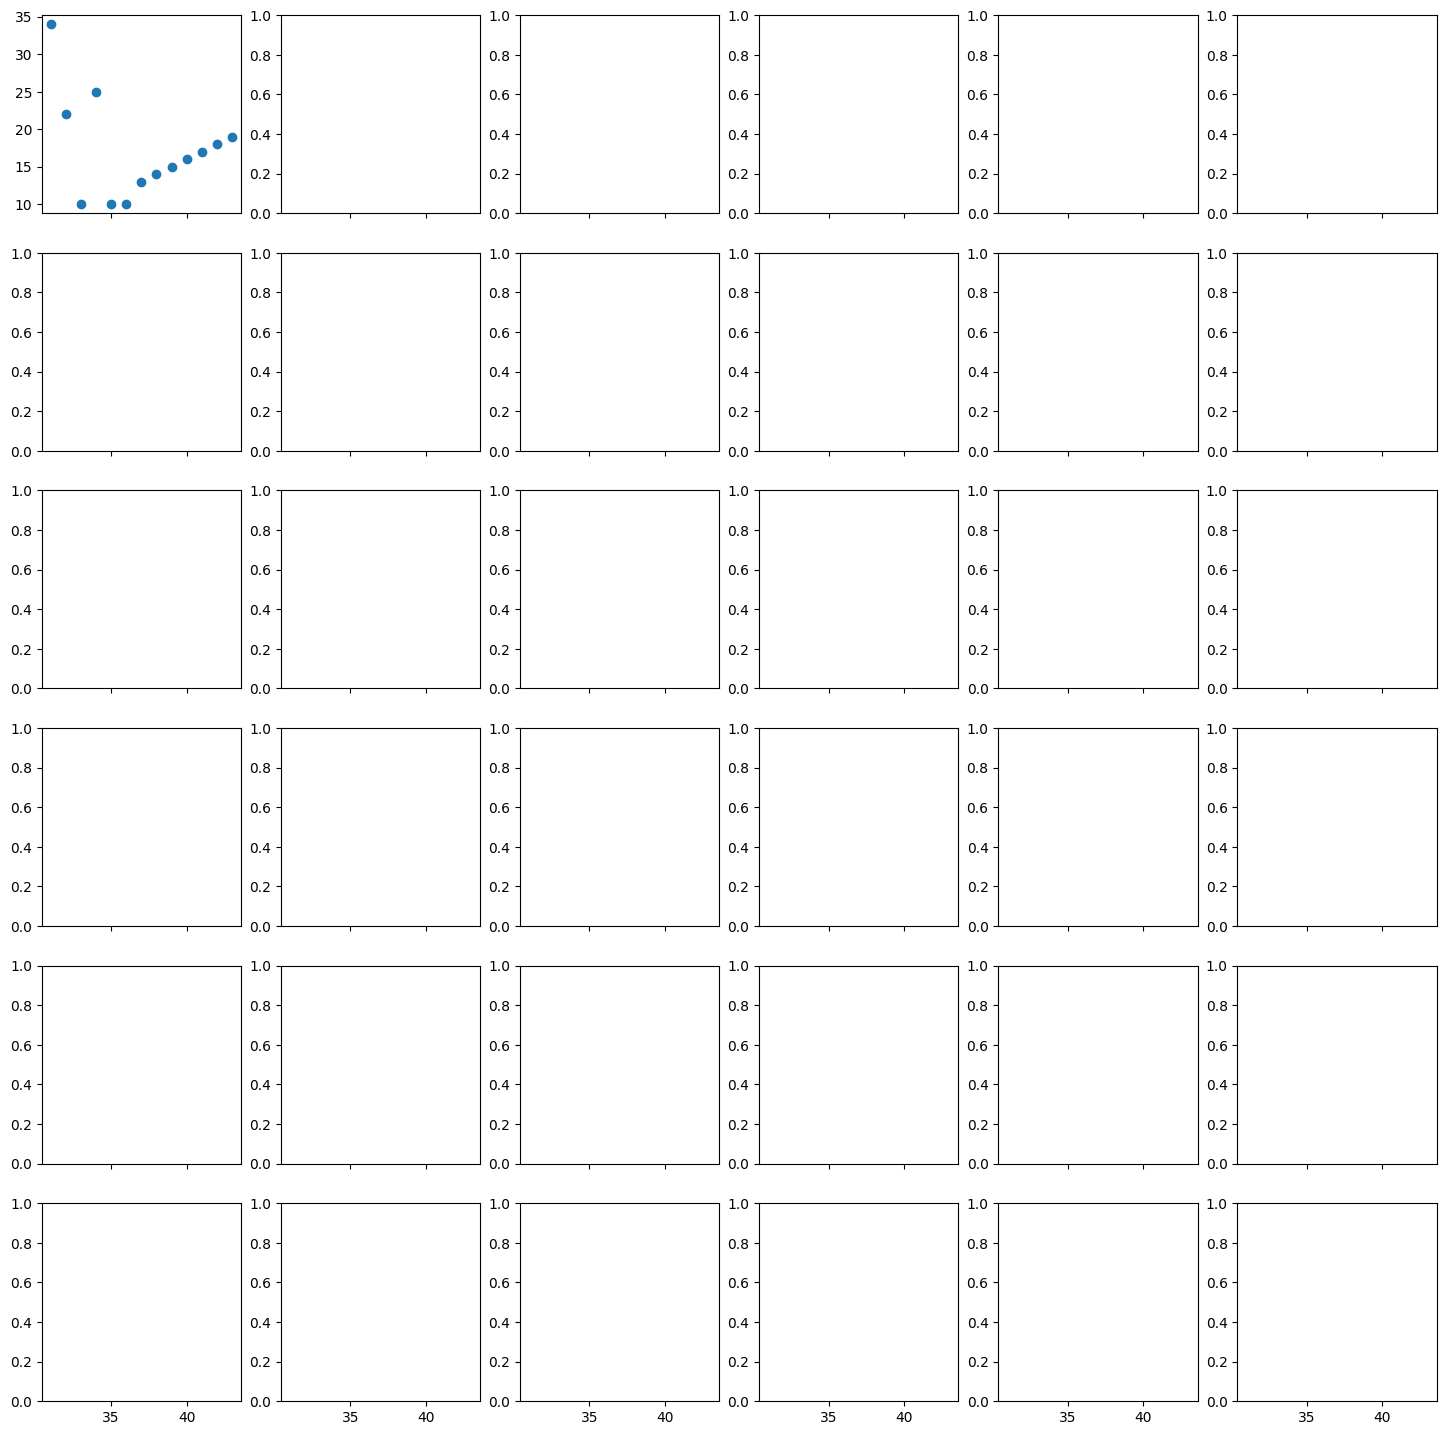

In [116]:
# d = load_raw_full()
# run_prophet(get_subset(d, 6))
plot_prophet(n=36)

In [117]:
def run_prophet_all(csv_name='results_prophet.csv'):
    if not os.path.isfile(csv_name):
        d = load_raw_full()
        d['total_claims'] = d['total_claims'].interpolate(method='linear')
        l = []
        for i, (uu_id, g) in enumerate(d.groupby('uu_id')):
            if i % 20 == 0:
                print(i)
            r = run_prophet(g)
            l.append(r)
        pred = pd.concat(l, ignore_index=True)
        pred.to_csv(csv_name, index=False)

In [118]:
run_prophet_all()

0


NameError: name 'prophet' is not defined

In [119]:
convert_to_submission('results_prophet.csv', week_number_to_submit=43)

FileNotFoundError: [Errno 2] No such file or directory: 'results_prophet.csv'